의학영상처리 midterm 대체과제
2070044 오예인

#Object detection (10점)
1. Yolo mark 혹은 robotflow 이용해서 왼손 오른손 레이블링 진행
2. yolo v5 혹은 다른 object detection 모델을 이용해서 학습 및 검증 및 테스트 진행
3. 평가지표 mAP 사용 train data 2개, validation 1개, test 1개, learning rate 0.003
4. 학습된 모델에 테스트 데이터 값을 넣어서 모델의 출력 값 및 테스트 데이터를 입력하여 mAP 값을 출력

###object detection을 실행을 위한 파일과 패키지 다운로드 및 임포트

In [1]:
# YOLOv5 레퍼지토리 clone
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16036, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 16036 (delta 39), reused 42 (delta 25), pack-reused 15967
Receiving objects: 100% (16036/16036), 14.67 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (11001/11001), done.


In [2]:
# 코드 수행을 위해 필요한 패키지 다운로드 및 임포트

!pip install pytube --upgrade
!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install uvicorn
!pip install pyparsing==2.4.7
!pip install numpy==1.23.5

%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import os
import sys
import sqlite3
import traceback
import logging

import torch
import yaml

from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.1 MB/s eta 0:00:00
ERROR: pip's 

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu118 (CPU)


### Roboflow에서 labeling한 데이터 가져오기

In [3]:
# roboflow를 통해 labeling한 데이터 받아오기
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZbhbbA0UcYsnPIJPjBZ3")
project = rf.workspace("yeinoh36").project("hand-xndvh")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to HAND-2 in yolov5pytorch:: 100%|██████████| 22/22 [00:00<00:00, 2611.79it/s]


### training 전 dataset 정리하기

In [4]:
# 데이터 파일의 위치 변경을 위한 함수 생성

logger = logging.getLogger('wpg_logger')
logging.basicConfig(encoding='utf-8', level=logging.INFO, format='%(levelname)s:%(name)s:%(asctime)s:%(message)s', filename='./logger.log', filemode='a')
logger.info('[Start]')

rootPath="/content"

logger.info('[makeDir]')
# 폴더 체크 후 없으면 생성
def makeDir(rootPath, dir):
  # root 경로에 원하는 폴더 이름 합치기
  dirPath = rootPath + "/" + dir
  # sqlDirPath에 폴더가 있는지 확인
  if os.path.exists(dirPath):
    logger.info('[makeDir] exists makeDirPath : '+ dirPath)

  else:
      os.makedirs(dirPath)
      logger.info('[makeDir] makedirs success : ' + dirPath)

In [5]:
# data 폴더 생성 및 이미지와 라벨 데이터 이동

logger.info('[logic]logic start')
makeDir(rootPath, 'data')

rootPath = "/content/data"
makeDir(rootPath, 'images')
makeDir(rootPath, 'labels')

rootPath = "/content/data/images"
makeDir(rootPath, 'train')
makeDir(rootPath, 'valid')
makeDir(rootPath, 'test')

rootPath = "/content/data/labels"
makeDir(rootPath, 'train')
makeDir(rootPath, 'valid')
makeDir(rootPath, 'test')

# images 이동
src = '/content/yolov5/HAND-2/train/images/sample_image4_png.rf.bca4a70d1036296b80e870b3d5d49b5e.jpg'
dest = '/content/data/images/train/sample_image4_png.rf.bca4a70d1036296b80e870b3d5d49b5e.jpg'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/train/images/sample_image_png.rf.084792c992b4df707536d39deb559740.jpg'
dest = '/content/data/images/train/sample_image_png.rf.084792c992b4df707536d39deb559740.jpg'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/valid/images/sample_image3_png.rf.e61a5d22085c4b13ca115e9630c60d1f.jpg'
dest = '/content/data/images/valid/sample_image3_png.rf.e61a5d22085c4b13ca115e9630c60d1f.jpg'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/valid/images/sample_image5_png.rf.b21e180d65eb0ae9ec5ebc3148bcb7c2.jpg'
dest = '/content/data/images/valid/sample_image5_png.rf.b21e180d65eb0ae9ec5ebc3148bcb7c2.jpg'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/test/images/sample_image2_png.rf.8d8f70bca117a0a4073b40ec4765c874.jpg'
dest = '/content/data/images/test/sample_image2_png.rf.8d8f70bca117a0a4073b40ec4765c874.jpg'
os.replace(src, dest)

# labels 이동
src = '/content/yolov5/HAND-2/train/labels/sample_image4_png.rf.bca4a70d1036296b80e870b3d5d49b5e.txt'
dest = '/content/data/labels/train/sample_image4_png.rf.bca4a70d1036296b80e870b3d5d49b5e.txt'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/train/labels/sample_image_png.rf.084792c992b4df707536d39deb559740.txt'
dest = '/content/data/labels/train/sample_image_png.rf.084792c992b4df707536d39deb559740.txt'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/valid/labels/sample_image3_png.rf.e61a5d22085c4b13ca115e9630c60d1f.txt'
dest = '/content/data/labels/valid/sample_image3_png.rf.e61a5d22085c4b13ca115e9630c60d1f.txt'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/valid/labels/sample_image5_png.rf.b21e180d65eb0ae9ec5ebc3148bcb7c2.txt'
dest = '/content/data/labels/valid/sample_image5_png.rf.b21e180d65eb0ae9ec5ebc3148bcb7c2.txt'
os.replace(src, dest)

src = '/content/yolov5/HAND-2/test/labels/sample_image2_png.rf.8d8f70bca117a0a4073b40ec4765c874.txt'
dest = '/content/data/labels/test/sample_image2_png.rf.8d8f70bca117a0a4073b40ec4765c874.txt'
os.replace(src, dest)

### data yaml 파일 수정하기

In [6]:
# data dir와 yaml 설정
data_dir = '/content/data'
data_yaml = 'HAND-2/data.yaml'

# 데이터셋 yaml 파일 확인
print('기존 yaml 파일 :')
with open(data_yaml) as f:
    film = yaml.load(f, Loader=yaml.FullLoader)
    display(film)

# yaml 파일의 train, val, test 데이터가 있는 경로 수정
film['train'] = '/content/data/images/train'
film['val'] = '/content/data/images/valid'
film['test'] = '/content/data/images/test'

with open(data_yaml, 'w') as f:
    yaml.dump(film, f)

# 수정된 data yaml 파일 확인
print('변경된 yaml 파일 :')
with open(data_yaml) as f:
    film = yaml.load(f, Loader=yaml.FullLoader)
    display(film)

기존 yaml 파일 :


{'names': ['left', 'right'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'hand-xndvh',
  'url': 'https://universe.roboflow.com/yeinoh36/hand-xndvh/dataset/2',
  'version': 2,
  'workspace': 'yeinoh36'},
 'test': '../test/images',
 'train': 'HAND-2/train/images',
 'val': 'HAND-2/valid/images'}

변경된 yaml 파일 :


{'names': ['left', 'right'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'hand-xndvh',
  'url': 'https://universe.roboflow.com/yeinoh36/hand-xndvh/dataset/2',
  'version': 2,
  'workspace': 'yeinoh36'},
 'test': '/content/data/images/test',
 'train': '/content/data/images/train',
 'val': '/content/data/images/valid'}

### hyp yaml 파일 수정하기

In [7]:
# hyp dir과 yaml 설정
hyp_dir = 'data/hyps'
hyp_yaml = 'data/hyps/hyp.scratch-low.yaml'

# hyp yaml 파일 확인
print('기존 hyp yaml 파일 :')
with open(hyp_yaml) as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
    display(hyp)

# yaml 파일의 learning rate 수정
hyp['lr0'] = 0.003

with open(hyp_yaml, 'w') as f:
    yaml.dump(hyp, f)

# 수정된 hyp yaml 파일 확인
print('변경된 hyp yaml 파일 :')
with open(hyp_yaml) as f:
    new_hyp = yaml.load(f, Loader=yaml.FullLoader)
    display(new_hyp)

기존 hyp yaml 파일 :


{'lr0': 0.01,
 'lrf': 0.01,
 'momentum': 0.937,
 'weight_decay': 0.0005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.05,
 'cls': 0.5,
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.5,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 1.0,
 'mixup': 0.0,
 'copy_paste': 0.0}

변경된 hyp yaml 파일 :


{'anchor_t': 4.0,
 'box': 0.05,
 'cls': 0.5,
 'cls_pw': 1.0,
 'copy_paste': 0.0,
 'degrees': 0.0,
 'fl_gamma': 0.0,
 'fliplr': 0.5,
 'flipud': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'iou_t': 0.2,
 'lr0': 0.003,
 'lrf': 0.01,
 'mixup': 0.0,
 'momentum': 0.937,
 'mosaic': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'perspective': 0.0,
 'scale': 0.5,
 'shear': 0.0,
 'translate': 0.1,
 'warmup_bias_lr': 0.1,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'weight_decay': 0.0005}

### train

In [8]:
# 결과를 시각화하기 위한 wandb 설치
!pip install wandb

# train 시작
!python train.py --img 640 --batch 16 --epochs 10 --data {data_yaml} --cfg '/content/yolov5/models/yolov5m.yaml' --weights yolov5s.pt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e2b3f28d102da9823e342c64126aa3c492d50d4e2f6eb0c5774b03404528de62
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2023-11-02 13:42:57.252567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 13:42:57.252642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempt

### test

In [9]:
# test를 실행하고 출력된 mAP 값 확인하기
!python val.py --task "test" --data {data_yaml} --weights runs/train/exp/weights/best.pt --save-txt

val: data=HAND-2/data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-232-g1c60c53 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning /content/data/labels/test... 1 images, 0 backgrounds, 0 corrupt: 100% 1/1 [00:00<00:00, 74.81it/s]
test: New cache created: /content/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.34s/it]
                   all          1          2    0.00694        0.5     0.0124    0.00124
                  left          1          1          0          0          0          0
            

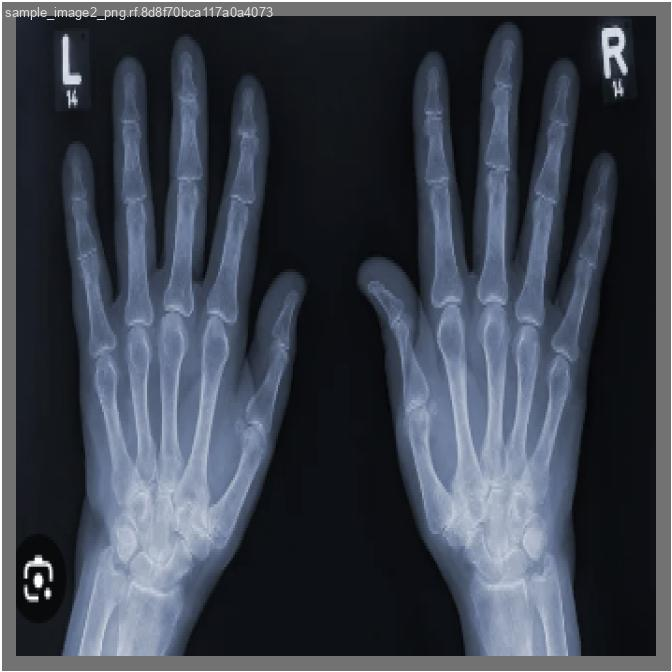

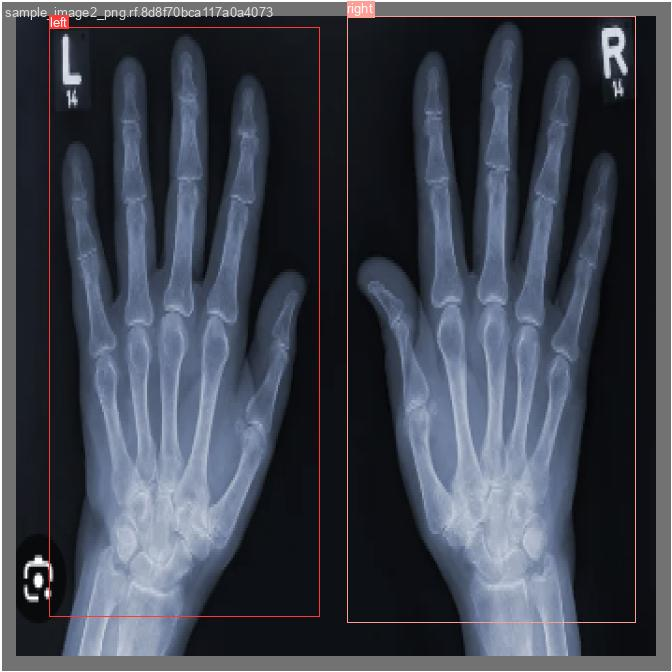

In [12]:
# 테스트 결과 이미지 확인하기
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/val/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")